<a href="https://colab.research.google.com/github/emmab-collab/Machine-Learning/blob/main/Student_Mental_Health/Preprocessing_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s4e11_path = kagglehub.competition_download('playground-series-s4e11')

print('Data source import complete.')


100%|██████████| 4.55M/4.55M [00:00<00:00, 6.46MB/s]

Extracting files...


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 1. Définir un objectif mesurable
## Objectif

Prédire si une personne est en dépression en fonction des données cliniques disponibles

## Métrique

- accuracy(précision) TP/(TP+FP) -> on veut pas de faux positifs, on veut pas envoyer à l'hôpital pour rien
- recall(sensibilité) TP/(TP+FN) -> on veut pas de faux négatifs, on veut surtout pas louper un positif
- F1score

Problème : classes déséquilibrées, on a déjà 82% des exemples qui ne sont pas en dépression donc on peut atteindre 0.82 accuracy
**Donc on ne choisit pas l'accuracy**

**Métrique** : F1 0.5 et Recall 0.7

# 2. EDA (Exploratory Data Analysis)
**Objectif** : Comprendre au mieux les données pour définir une stratégie de modélisation.

* **Analyse de la forme :**
  * **Identification de la target** : Depression
  * **Nombre de lignes et colonnes** : 140700, 20
  * **Type de variables** : qualitatives : 10, quantitatives : 10
  * **Identification des valeurs manquantes** :
    * 3 variables ont beaucoup de NaN (>80%)
    * 2 groupes de données : 80% -> studies (Academic Pressure, CGPA,Study Satisfaction), 20% -> job (Profession, Work Pressure, Job Satisfaction)
    
* **Analyse du fond :**
  * **Visualisation de la target** :
    * 18% de cas de Dépression, 82% de cas sains
  * **Compréhension des différentes variables**
    * Variables continues : beaucoup de catégories chiffrées
    * Variables qualitatives : énormément de catégories (nom, métiers, études), globalement que des villes indiennes, bcp de profs intérrogés et moins d'étudiants (1/5) que de travailleurs (4/5)
    * Age : de 20 à 60 ans
  * **Visualisation des relations features-target**:
    * job/ target :
      - plus grande work pressure et faible job estimation chez les deprimés
      - heures de travail/study semble plus élevée chez les Déprimés
    * studies / target :
      - il semblerait que les étudiants sont bcp plus déprimés que les travailleurs
      - beaucoup de 'class 12' dans les déprimés (aucune info supplémentaire)
      - academic pressure plus grande pour les étudiants déprimés

    * age / target :
      - les 20-30 ans semblent beaucoup plus déprimés
    * hygiène de vie / Target :
      - il semblerait que la duréé de sommeil et le régime alimentaire joue un rôle dans la dépression --> hypothèse à tester
      - financiel stress plus élevé chez les déprimés
    * variables object :
      - il semblerait y avoir un fort lien entre les idées suicidaires et la dépression
  * **Identification des outliers**

In [ ]:
import os
link=os.path.join(playground_series_s4e11_path, 'train.csv')
#data=pd.read_excel(link)
data=pd.read_csv(link)
df=data.copy()
df

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0


# 3. Pre-processing
**Objectif** : Transformer le dataset pour le préparer au Machine Learning

* **Objectif 1: mettre les données dans un format propice au ML**
    * Train / Test
    * Encodage
    * Nettoyage des NaN

--> Dataset réduit à
* 22353 rows × 16 columns pour X_train
    * en enlevant les nan des cgpa

--> premier modèle : évaluation - diagnostic

* **Objectif 2 : améliorer la performance du modèle**
    * Feature Selection
    * Feature Engineering
    * Feature Scaling
    * Suppression des Outliers

## **Création des sous-ensembles (suite au EDA)**

In [ ]:
target_feature='Depression'

## **Traintest**

In [ ]:
from sklearn.model_selection import train_test_split
trainset,testset=train_test_split(df,test_size=0.2,random_state=42)
print(f'Les proportions de {target_feature} dans le trainset sont :\n')
trainset[target_feature].value_counts()

Les proportions de Depression dans le trainset sont :



,count
Depression,
0,92147
1,20413


In [ ]:
print(f'Les proportions de {target_feature} dans le testset sont :\n')
testset[target_feature].value_counts()

Les proportions de Depression dans le testset sont :



,count
Depression,
0,22986
1,5154


In [ ]:
testset.isna().sum()

,0
id,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,7296
Academic Pressure,22596
Work Pressure,5548
CGPA,22595


In [ ]:
trainset.isna().sum()

,0
id,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,29334
Academic Pressure,90207
Work Pressure,22370
CGPA,90207


## **Encodage**

**A encoder :**

*Name*
*Gender*
*City*
*Working Professional or Student*
*Profession*
*Sleep Duration*
*Dietary Habits*
*Degree*
*Have you ever had suicidal thoughts ?*
*Family History of Mental Illness*

In [ ]:
def encodage(df):
    sommeil={
        "More than 8 hours":9,
        'Less than 5 hours':4,
        '5-6 hours':5.5,
        '7-8 hours':7.5,
        '1-2 hours':1.5,
        '6-8 hours':7,
        '4-6 hours':5,
        '6-7 hours':6.5,
        '10-11 hours':10.5,
        '8-9 hours':8.5,
        '9-11 hours':10,
        '2-3 hours':2.5,
        '3-4 hours':3.5,
        'Moderate':6,
        '4-5 hours':4.5,
        '9-6 hours':7.5,
        '1-3 hours':2,
        '1-6 hours':4,
        '8 hours':8,
        '10-6 hours':8,
        'Unhealthy':3,
        'Work_Study_Hours':6,
        '3-6 hours':3.5,
        '9-5':7,
        '9-5 hours':7}



    diet={
        'More Healty':0,
        'Healthy':1,
        'Less than Healthy':2,
        'Less Healthy':2,
        'Moderate':3,
        'Unhealthy':4,
        'No Healthy':4}


    sommeil={
        "More than 8 hours":9,
        'Less than 5 hours':4,
        '5-6 hours':5.5,
        '7-8 hours':7.5,
        '1-2 hours':1.5,
        '6-8 hours':7,
        '4-6 hours':5,
        '6-7 hours':6.5,
        '10-11 hours':10.5,
        '8-9 hours':8.5,
        '9-11 hours':10,
        '2-3 hours':2.5,
        '3-4 hours':3.5,
        'Moderate':6,
        '4-5 hours':4.5,
        '9-6 hours':7.5,
        '1-3 hours':2,
        '1-6 hours':4,
        'Healthy':1,
        'Less than Healthy':2,
        'Less Healthy':2,
        'Moderate':3,
        'Unhealthy':4,
        'No Healthy':4}

    degree = {
        "BCom" :"B.Com", "B.Com": "B.Com", "B.Comm": "B.Com",
        "B.Tech": "B.Tech", "BTech": "B.Tech", "B.T": "B.Tech",
        "BSc" : "B.Sc", "B.Sc": "B.Sc", "Bachelor of Science": "B.Sc",
        "BArch": "B.Arch", "B.Arch": "B.Arch",
        "BA" : "B.A", "B.A": "B.A",
        "BBA": "BBA", "BB": "BBA",
        "BCA": "BCA",
        "BE": "BE",
        "BEd": "B.Ed", "B.Ed": "B.Ed",
        "BPharm": "B.Pharm", "B.Pharm": "B.Pharm",
        "BHM": "BHM",
        "LLB": "LLB", "LL B": "LLB", "LL BA": "LLB", "LL.Com": "LLB", "LLCom": "LLB",
        "MCom": "M.Com", "M.Com": "M.Com",
        "M.Tech": "M.Tech", "MTech": "M.Tech", "M.T": "M.Tech",
        "MSc": "M.Sc", "M.Sc": "M.Sc", "Master of Science": "M.Sc",
        "MBA": "MBA",
        "MCA": "MCA",
        "MD": "MD",
        "ME": "ME",
        "MEd": "M.Ed", "M.Ed": "M.Ed",
        "MArch": "M.Arch", "M.Arch": "M.Arch",
        "MPharm": "M.Pharm", "M.Pharm": "M.Pharm",
        "MA": "MA", "M.A": "MA",
        "MPA": "MPA",
        "LLM": "LLM",
        "PhD": "PhD",
        "MBBS": "MBBS",
        "CA": "CA",
        "Class 12": "Class 12", "12th": "Class 12",
        "Class 11": "Class 11", "11th": "Class 11"}

    mean_per_city = trainset.groupby('City')[target_feature].mean()
    mean_per_name = trainset.groupby('Name')[target_feature].mean()
    mean_per_profession=trainset.groupby('Profession')[target_feature].mean()
    mean_per_degree=trainset.groupby('Degree')[target_feature].mean()

    code={
        'Female':1,
        'Male':0,
        'Working Professional':1,
        'Student':0,
        'Yes':1,
        'No':0 }


    df['Dietary Habits'] = df['Dietary Habits'].map(diet)
    df['Sleep Duration'] = df['Sleep Duration'].map(sommeil)
    df['Degree'] = df['Degree'].map(degree)

    df['City']=df['City'].map(mean_per_city)
    df['Name'] = df['Name'].map(mean_per_name)
    df['Profession'] = df['Profession'].map(mean_per_profession)
    df['Degree'] = df['Degree'].map(mean_per_degree)


    for col in ['Gender','Working Professional or Student','Have you ever had suicidal thoughts ?','Family History of Mental Illness']:
        df[col]=df[col].map(code)

    df.drop('id',axis=1,inplace=True)

    return df

## **Imputation**
**Pour l'imputation, il faut traiter :**

*Study Satisfaction*      
*Academic Pressure*                    
CGPA                                    
Profession                            
*Work Pressure*                           
*Job Satisfaction*                       
Dietary Habits                           
Financial Stress                        
Degree

In [ ]:
def imputation(df):
    df['Pressure'] = np.where(df['Working Professional or Student'] == 0,df['Academic Pressure'],df['Work Pressure'])
    df['Satisfaction'] = np.where(df['Working Professional or Student'] == 0,df['Study Satisfaction'],df['Job Satisfaction'])

    df.drop(['Academic Pressure', 'Work Pressure','Study Satisfaction','Job Satisfaction'], axis=1, inplace=True)
    nan_columns=['Profession','Name','City','Financial Stress','Sleep Duration','Dietary Habits','Degree','Pressure','Satisfaction']
    for col in nan_columns:
        df[col]=df[col].fillna(np.nanmedian(trainset[col]))
        #print(np.nanmedian(trainset[col]))
    #df=df.dropna(axis=0)
    df=df.dropna(subset=['CGPA'])
    #df=df.fillna(-999)
    return df

In [ ]:
def preprocessing(df):
    df=encodage(df)
    #df=feature_engineering(df)
    df=imputation(df)
    #print(df.columns.tolist())
    #print(df.isna().sum(axis=0))

    X=df.drop(target_feature,axis=1)
    y=df[target_feature]

    print(y.value_counts())

    return X,y

In [ ]:
X_train,y_train=preprocessing(trainset)

Depression
1    13061
0     9292
Name: count, dtype: int64


In [ ]:
X_test,y_test=preprocessing(testset)

Depression
1    3275
0    2270
Name: count, dtype: int64


In [ ]:
X_train

,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Pressure,Satisfaction
5255,0.250000,1,25.0,0.127900,0,0.05639,7.35,9.0,3.0,0.151501,1,0.0,1.0,1,5.0,3.0
33054,0.141689,1,34.0,0.147374,0,0.05639,5.59,7.5,3.0,0.131114,0,10.0,2.0,0,2.0,5.0
2182,0.342644,0,28.0,0.207945,0,0.05639,8.35,4.0,4.0,0.164848,1,6.0,1.0,1,2.0,2.0
78935,0.111111,1,24.0,0.188456,0,0.05639,8.25,7.5,3.0,0.151501,1,0.0,5.0,0,3.0,4.0
3643,0.177966,0,27.0,0.202061,0,0.05639,5.11,5.5,4.0,0.143496,0,10.0,2.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65725,0.267875,0,21.0,0.204167,0,0.05639,8.96,4.0,1.0,0.161800,1,10.0,5.0,0,5.0,1.0
5311,0.211089,1,23.0,0.185871,0,0.05639,8.95,4.0,3.0,0.155237,1,7.0,2.0,0,3.0,4.0
64925,0.211089,1,23.0,0.188456,0,0.05639,7.51,9.0,4.0,0.155191,1,8.0,5.0,1,4.0,4.0
67221,0.319588,0,18.0,0.198536,0,0.05639,7.70,5.5,1.0,0.203472,1,7.0,5.0,0,1.0,5.0


## **Modelisation**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [ ]:
model=make_pipeline(PolynomialFeatures(2,include_bias=False),RandomForestClassifier(random_state=42))
#model=make_pipeline(SelectKBest(f_classif,k=15),RandomForestClassifier(random_state=42))
# k=10[précision Recall F1] 0.84      0.79      0.82
# k=15 0.85      0.79      0.82
# sans selectKbest = 0.85      0.79      0.82
# avec PolynomialFeatures(2) : 0.85      0.80      0.82

## **Procédure d'évaluation**

In [ ]:
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.model_selection import learning_curve

In [ ]:
def evaluation(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    N,train_score,val_score=learning_curve(model,X_train,y_train,
                                            cv=4,scoring='f1',
                                            train_sizes=np.linspace(0.1,1,5))
    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),label='train score')
    plt.plot(N,val_score.mean(axis=1),label='validation score')
    plt.legend()

[[1802  468]
 [ 426 2849]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2270
           1       0.86      0.87      0.86      3275

    accuracy                           0.84      5545
   macro avg       0.83      0.83      0.83      5545
weighted avg       0.84      0.84      0.84      5545



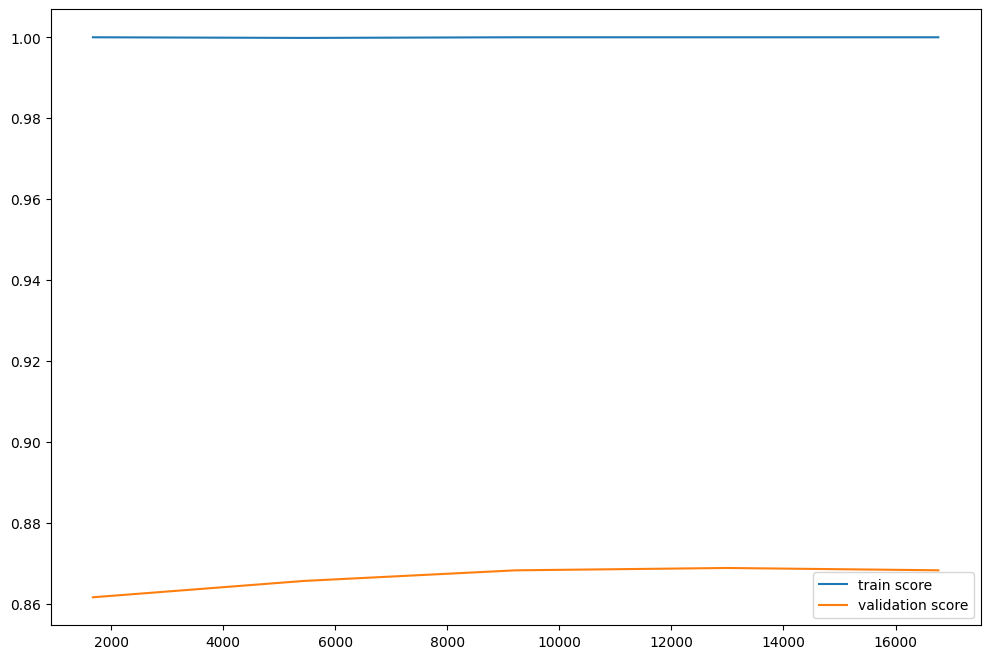

In [ ]:
evaluation(model)

In [ ]:
#(pd.DataFrame(model.feature_importances_,index=X_train.columns)).plot.bar(figsize=(12,8))

# 4. Modelling
**Objectif** : développer un modèle de Machine Learning
 qui réponde à l'objectif final

* Définir une fonction d'évaluation : fait dans la partie Preprocessing
  * RandomForestClassifier : 0.86      0.87      0.86
  * SelectKBest inutile
  * PolynomialFeature(2) : 0.85      0.80      0.82
* Entrainement de différents modèles
   (precision Recall F1-score)
  * RandomForest : 0.86      0.87      0.86
  * AdaBoost : 0.87      0.86      0.86
  * SVM : 0.86      0.87      0.86
  * KNN :  0.85      0.85      0.85
  * Entre le score et la convergence, on opte pour AdaBoost
* Optimisation avec GridSearchCV
   * On trouve {algorithm': 'SAMME.R',max_depth=1,learning_rate': 1.0, n_estimators': 100}
   * score du best_estimator : 0.86      0.87      0.86
* (Optionnel) Analyse des erreurs et retour au Preprocessing/EDA
* Learning Curve et prise de décision

## **Entrainement de différents modèles**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
preprocessor=make_pipeline(PolynomialFeatures(2,include_bias=False))

In [ ]:
RandomForest=make_pipeline(preprocessor,RandomForestClassifier(random_state=42))
AdaBoost=make_pipeline(preprocessor, AdaBoostClassifier(random_state=42))
SVM=make_pipeline(preprocessor,StandardScaler(),SVC(random_state=42))
KNN=make_pipeline(preprocessor,StandardScaler(),KNeighborsClassifier())

list_of_models={'RandomForest':RandomForest,
                'AdaBoost':AdaBoost,
                'SVM':SVM,
                'KNN':KNN}

RandomForest
[[1802  468]
 [ 426 2849]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2270
           1       0.86      0.87      0.86      3275

    accuracy                           0.84      5545
   macro avg       0.83      0.83      0.83      5545
weighted avg       0.84      0.84      0.84      5545

AdaBoost
[[1829  441]
 [ 455 2820]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2270
           1       0.86      0.86      0.86      3275

    accuracy                           0.84      5545
   macro avg       0.83      0.83      0.83      5545
weighted avg       0.84      0.84      0.84      5545

SVM
[[1802  468]
 [ 426 2849]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2270
           1       0.86      0.87      0.86      3275

    accuracy                           0.84      5545
   macro avg       0.

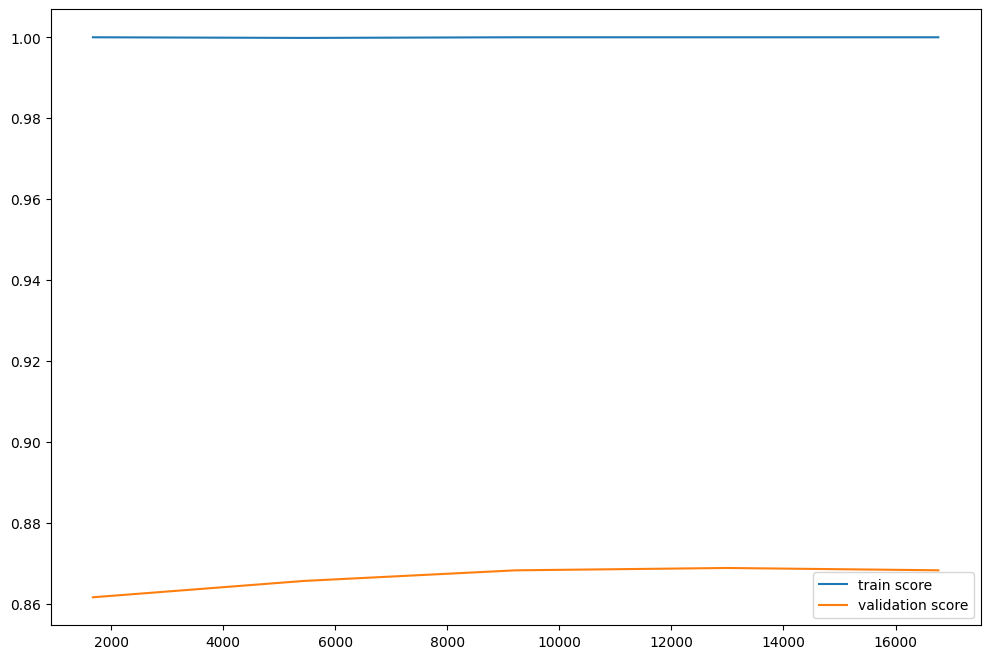

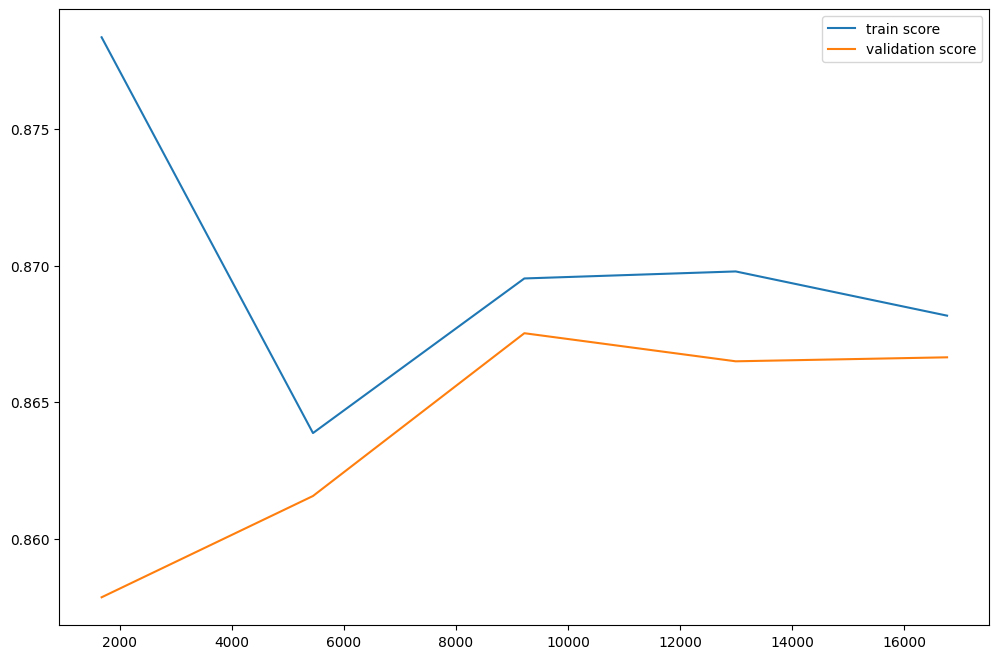

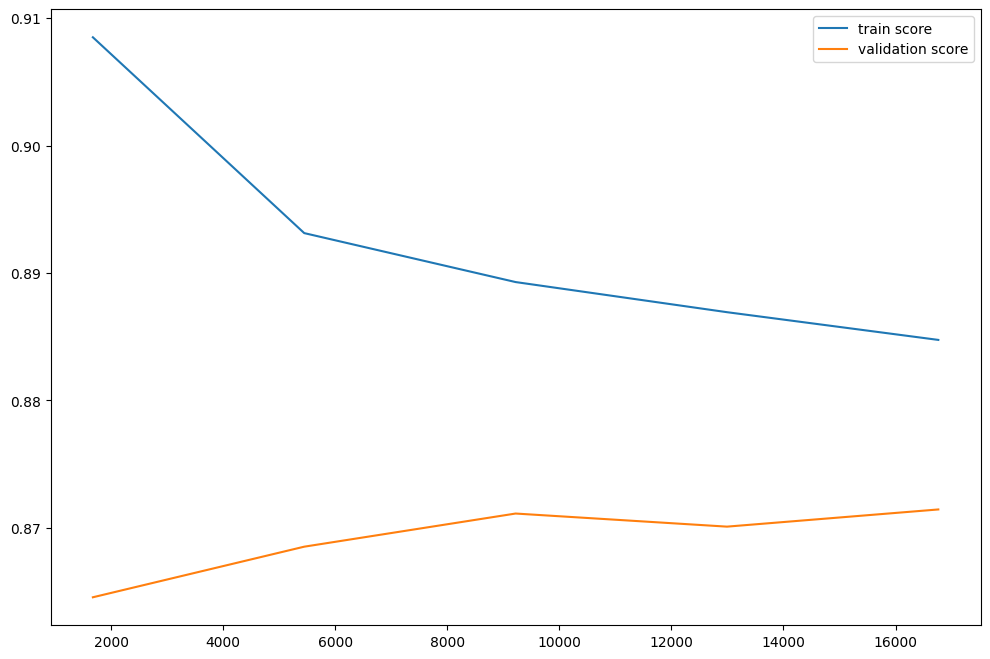

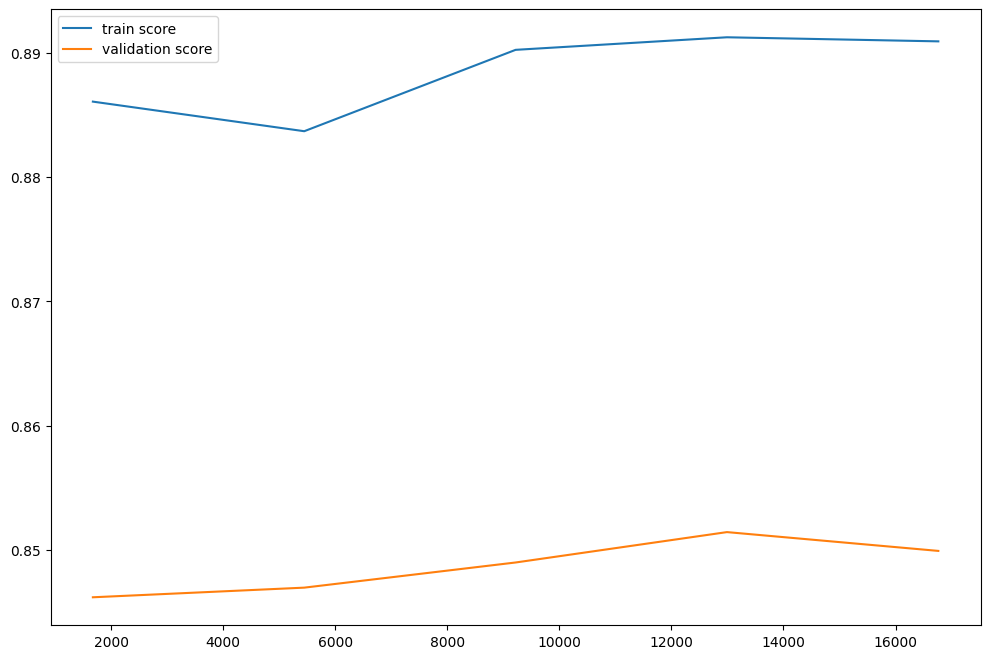

In [ ]:
for name,model in list_of_models.items():
    print(name)
    evaluation(model)

## **Optimisation**

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
AdaBoost

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False))])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=42))])

In [ ]:
AdaBoost.get_params()

{'memory': None,
 'steps': [('pipeline',
   Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False))])),
  ('adaboostclassifier', AdaBoostClassifier(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'pipeline': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False))]),
 'adaboostclassifier': AdaBoostClassifier(random_state=42),
 'pipeline__memory': None,
 'pipeline__steps': [('polynomialfeatures',
   PolynomialFeatures(include_bias=False))],
 'pipeline__transform_input': None,
 'pipeline__verbose': False,
 'pipeline__polynomialfeatures': PolynomialFeatures(include_bias=False),
 'pipeline__polynomialfeatures__degree': 2,
 'pipeline__polynomialfeatures__include_bias': False,
 'pipeline__polynomialfeatures__interaction_only': False,
 'pipeline__polynomialfeatures__order': 'C',
 'adaboostclassifier__algorithm': 'deprecated',
 'adaboostclassifier__estimator': None,
 'adaboostclassifier__learning_rate': 1.0,
 'adaboostclassifier__n

In [ ]:
hyper_params={
    'adaboostclassifier__n_estimators': [100],
    'adaboostclassifier__learning_rate': [1.0],

    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=3)]}


In [ ]:
grid=GridSearchCV(AdaBoost,hyper_params,scoring='recall',cv=4)

grid.fit(X_train,y_train)

print(grid.best_params_)

y_pred=grid.predict(X_test)

print(classification_report(y_test,y_pred))

{'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__estimator': DecisionTreeClassifier(max_depth=1), 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2270
           1       0.87      0.86      0.86      3275

    accuracy                           0.84      5545
   macro avg       0.83      0.83      0.83      5545
weighted avg       0.84      0.84      0.84      5545



[[1838  432]
 [ 460 2815]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2270
           1       0.87      0.86      0.86      3275

    accuracy                           0.84      5545
   macro avg       0.83      0.83      0.83      5545
weighted avg       0.84      0.84      0.84      5545



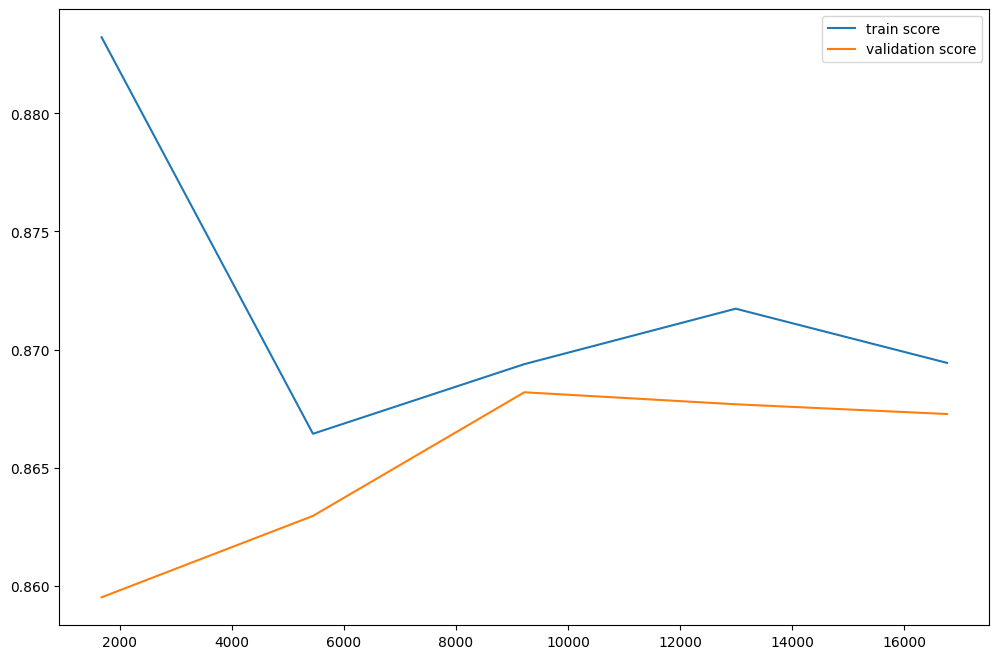

In [ ]:
evaluation(grid.best_estimator_)

## **Precision Recall Curve**

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precision,recall,threshold=precision_recall_curve(y_test,grid.best_estimator_.decision_function(X_test))

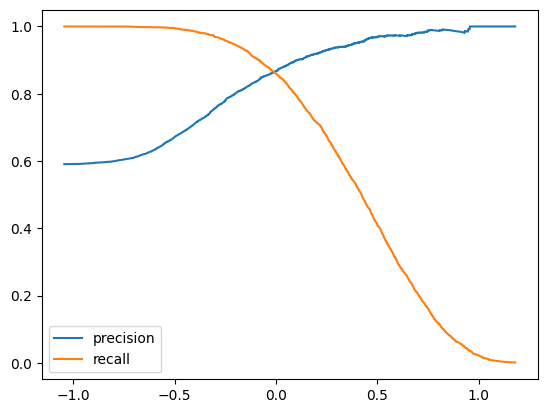

In [ ]:
plt.plot(threshold,precision[:-1],label='precision')
plt.plot(threshold,recall[:-1],label='recall')

plt.legend()

In [ ]:
def model_final(model,X,threshold=0):
    return model.decision_function(X)>threshold

In [ ]:
y_pred=model_final(grid.best_estimator_,X_test,threshold=-0.01)

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
f1_score(y_test,y_pred)

0.8641221374045801

In [ ]:
recall_score(y_test,y_pred)

0.8641221374045801

# **5. Bilan**
**Notre objectif était** F1 0.5 et Recall 0.7

**Ici on a surpassé l'objectif** : F1 0.86 et Recall 0.94

# **6. Submission**

In [ ]:
modele = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME.R',
    learning_rate=1.0,
    n_estimators=100)
modele.fit(X_train,y_train)

In [ ]:
link='/kaggle/input/playground-series-s4e11/test.csv'
#data=pd.read_excel(link)
df_test=pd.read_csv(link)
df=df_test.copy()

In [ ]:
def test_imputation(df):
    df['Pressure'] = np.where(df['Working Professional or Student'] == 0,df['Academic Pressure'],df['Work Pressure'])
    df['Satisfaction'] = np.where(df['Working Professional or Student'] == 0,df['Study Satisfaction'],df['Job Satisfaction'])

    df.drop(['Academic Pressure', 'Work Pressure','Study Satisfaction','Job Satisfaction'], axis=1, inplace=True)
    nan_columns=['CGPA','Profession','Name','City','Financial Stress','Sleep Duration','Dietary Habits','Degree','Pressure','Satisfaction']
    for col in nan_columns:
        df[col]=df[col].fillna(np.nanmedian(trainset[col]))
        #print(np.nanmedian(trainset[col]))
    #df=df.dropna(axis=0)
    #df=df.dropna(subset=['CGPA'])
    #df=df.fillna(-999)
    return df

In [ ]:
def test_preprocessing(df):
    df=encodage(df)
    #df=feature_engineering(df)
    df=test_imputation(df)
    #print(df.columns.tolist())
    #print(df.isna().sum(axis=0))

    #print(df.value_counts())

    return df

In [ ]:
predictions=test_preprocessing(df)

In [ ]:
predictions=model_final(modele,predictions,threshold=-0.01)

In [ ]:
predictions=predictions.astype(int)

In [ ]:
submission = pd.DataFrame({
    'id': testset['id'].values,
    'Depression': predictions
})

submission.to_csv("submission.csv", index=False, header=True)

In [ ]:
submission